In [7]:
####### Trying to implement Micrograd #######


In [2]:
import math 

In [40]:
class Value:
    def __init__(self,data,children=(),op='',label=''):
        # initialize data 
        self.data = data 
        self._backward = lambda: None
        self._prev = set(children)
        self._op = op
        self.label = label
        self.grad = 0.0

    def __repr__(self):
        # __repr__ is a way to beautify the output  
        return f'Value = {self.data}'
    def __add__(self,next_operand):
        operation = self.data+next_operand.data
        operation = Value(operation,(self,next_operand),'+')
        
        def _backward():
            self.grad += 1.0*operation.grad
            next_operand.grad += 1.0*operation.grad
        operation._backward = _backward

        return operation

    def __sub__(self,next_operand):
        operation = self.data - next_operand.data
        operation = Value(operation,(self,next_operand),'-')

        def _backward():
            self.grad += 1.0*operation.grad
            next_operand.grad += 1.0*operation.grad
            
        operation._backward = _backward

        return operation

    def __mul__(self,next_operand):
        operation = self.data * next_operand.data
        operation = Value(operation,(self,next_operand),'*')

        def _backward():
            self.grad += operation.grad*next_operand.data
            next_operand.grad += operation.grad*self.data

        operation._backward = _backward
        return operation
    
    def sigmoid(self):
        sig =  (1/(1+math.exp(-self.data)))
        operation = Value(sig,(self,),'sigmoid')

        def _backward():
            self.grad += sig*(1-sig)*operation.grad
        operation._backward = _backward

        return operation

    def backprop(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()
            

    
    
    # def __truediv__(self,next_operand):
    #     operation = self.data/next_operand.data
    #     return Value(operation,(self,next_operand),'/')


In [4]:
# graphviz code is by andrej karpathyfrom graphviz import Digraph
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

In [41]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.sigmoid(); o.label = 'o'

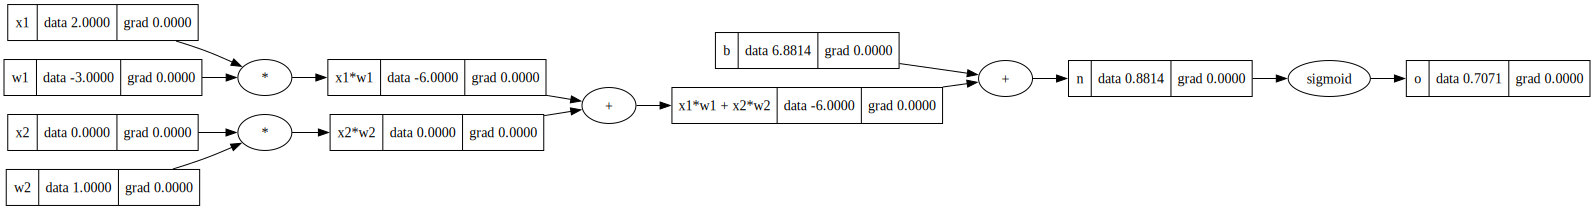

In [32]:
draw_dot(o)

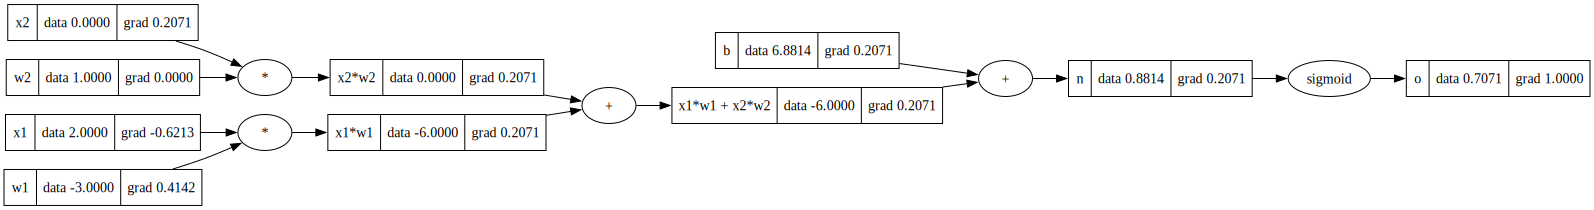

In [30]:
# o.grad = 1 
o._backward()
n._backward()
b._backward()
x1w1x2w2._backward()
x2w2._backward()
x1w1._backward()
draw_dot(o)

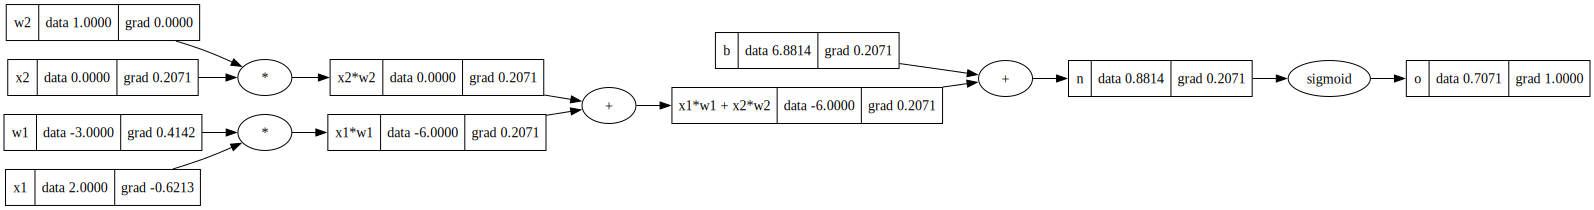

In [42]:
o.backprop()
draw_dot(o)